<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Logistic Regression</h1>
    </div>
</div>

**TL;DR**</br>
The code imports necessary libraries for text classification, preprocesses the data using TF-IDF, trains a logistic regression model, evaluates it on a validation set, and then evaluates it further on a test set, calculating accuracy, precision, recall, and F1-score.

**Summary**</br>
In this code, a dataset is loaded from a SingleStore database, containing text data and corresponding labels denoting fraud or non-fraud instances. The text data is preprocessed using TF-IDF vectorization. Then, a logistic regression model is trained on the preprocessed text data. The model is evaluated on a validation set, computing accuracy, precision, recall, and F1-score. Subsequently, the model is evaluated on a separate test set, calculating the same evaluation metrics. Additionally, the code includes functions to plot a confusion matrix, ROC curve, and precision-recall curve for visualisation of the model's performance on the validation set. Finally, these visualisations are generated and displayed.

In [3]:
!pip cache purge --quiet

In [4]:
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import numpy as np
import itertools

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [6]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [7]:
dataset = pd.read_sql(
    "SELECT Fraud, Filings FROM financial_filings",
    con = db_connection
)

In [8]:
text_data = dataset["Filings"]
labels = dataset["Fraud"]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
positive_label = label_encoder.transform(["yes"])[0]

X_temp, X_test, y_temp, y_test = train_test_split(text_data, labels, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 42) # 0.25 x 0.8 = 0.2 for validation

In [9]:
# Preprocess Text Data with TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Logistic Regression Model:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_tfidf, y_train)

# Evaluate Model on Validation Set:
y_val_pred = logistic_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, pos_label = positive_label)
val_recall = recall_score(y_val, y_val_pred, pos_label = positive_label)
val_f1 = f1_score(y_val, y_val_pred, pos_label = positive_label)

# Evaluate Model on Test Set:
y_test_pred = logistic_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=positive_label)
test_recall = recall_score(y_test, y_test_pred, pos_label = positive_label)
test_f1 = f1_score(y_test, y_test_pred, pos_label = positive_label)

In [10]:
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1)

print("test Accuracy:", test_accuracy)
print("test Precision:", test_precision)
print("test Recall:", test_recall)
print("test F1-score:", test_f1)

Validation Accuracy: 0.7058823529411765
Validation Precision: 0.7619047619047619
Validation Recall: 0.7619047619047619
Validation F1-score: 0.7619047619047619
test Accuracy: 0.8529411764705882
test Precision: 0.7619047619047619
test Recall: 1.0
test F1-score: 0.8648648648648649


In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, title = "Confusion matrix", cmap = plt.cm.Reds):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc = "lower right")

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    average_precision = average_precision_score(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision, lw = 2, label = "Average Precision = %0.2f" % average_precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc = "upper right")

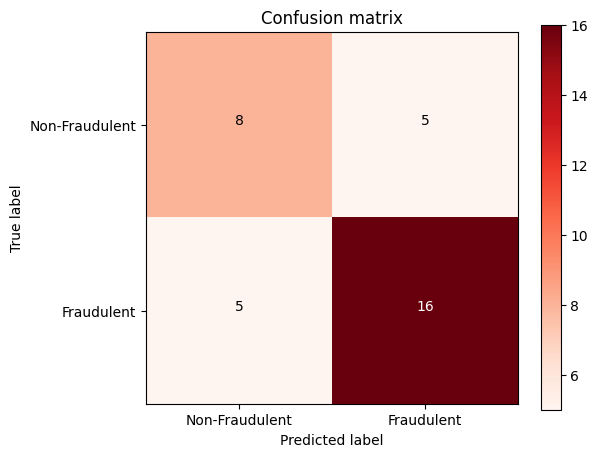

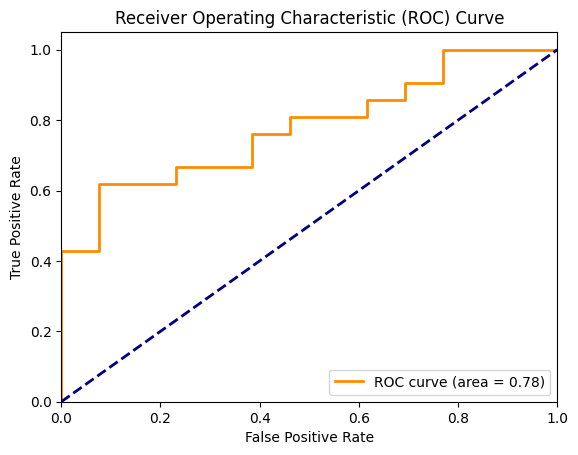

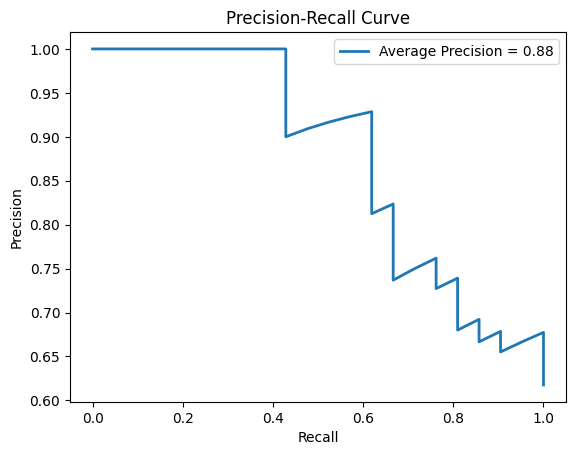

In [12]:
# Evaluate Model on Validation Set:
y_val_prob = logistic_model.predict_proba(X_val_tfidf)[:, 1]

# Plotting the confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize = (6, 5))
plot_confusion_matrix(y_val, y_val_pred, classes = ["Non-Fraudulent", "Fraudulent"])
plt.show()

plot_roc_curve(y_val, y_val_prob)
plt.show()

plot_precision_recall_curve(y_val, y_val_prob)
plt.show()

[Financial-Fraud-Detection-Using-LLMs](https://github.com/amitkedia007/Financial-Fraud-Detection-Using-LLMs)

## MIT License

Copyright (c) 2023 Amit Kedia

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.